# Рекомендация тарифов

Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных уже сделана

Построим модель с максимально большим значением *accuracy*. 

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [24]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

## Разбиение данных на выборки

Разделим датасет на тренировочную, валидационную и тестовую выборку в пропорциях 60%, 20% и 20% соответственно.

In [25]:
#Разобьем датасет на целевой признак и признаки
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [26]:
#Разобьем датасет на тренировочные данные и оставшуюся выборку
features_train, features_rem, target_train, target_rem = train_test_split(features, target, 
                                                                          test_size = 0.4, random_state=12345)

In [27]:
#Оставшуюся выборку разобьем на валидационную и тестовую
features_val, features_test, target_val, target_test = train_test_split(features_rem, target_rem, 
                                                                          test_size = 0.5, random_state=12345)

## Исследование модели

### Проверим модель с алгоритмом решающего дерева с разной глубиной.

In [29]:
best_model_dtc = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predictions_val = model.predict(features_val) 
    result = accuracy_score(target_val, predictions_val) 
    if result > best_result:
        best_model_dtc = model
        best_depth = depth
        best_result = result
        
print(f"""
        Accuracy лучшей моделина валидационной выборке:{best_result}. 
        Глубина лучшей модели {best_depth}.""")


        Accuracy лучшей моделина валидационной выборке:0.7853810264385692. 
        Глубина лучшей модели 3.


### Проверим случайный лес с разным количеством деревьев и разной глубиной.

In [30]:
best_model_rfc = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        predictions_val = model.predict(features_val) 
        result = accuracy_score(target_val, predictions_val) 
        if result > best_result:
            best_model_rfc = model
            best_result = result
            best_est = est
            best_depth = depth

print(f"""
        Accuracy наилучшей модели на валидационной выборке: {best_result}. 
        Количество деревьев: {best_est}. 
        Максимальная глубина: {depth}.""")


        Accuracy наилучшей модели на валидационной выборке: 0.8087091757387247. 
        Количество деревьев: 40. 
        Максимальная глубина: 10.


### Проверим логистическую регрессию.

In [31]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train) 
predictions_val = model_lr.predict(features_val) 
result = accuracy_score(target_val, predictions_val) 

print(f"Accuracy модели на валидационной выборке: {result}.")        
        

Accuracy модели на валидационной выборке: 0.7107309486780715.


**Вывод: модель случайного леса с количеством деревьев равным 40 и максимальной глубиной показала лучший результат Accurecy.**

## Проверьте модель на тестовой выборке

In [32]:
# Проверим модель, которая показала лучшие результаты на валидационной выборке.

predictions_test = best_model_rfc.predict(features_test) 
result = accuracy_score(target_test, predictions_test)

print(f"Accuracy модели на тестовой выборке: {result}.")

Accuracy модели на тестовой выборке: 0.7962674961119751.


## Проверим модели на адекватность

Рассмотрим наши модели при помощи метода plot_confusion_matrix.

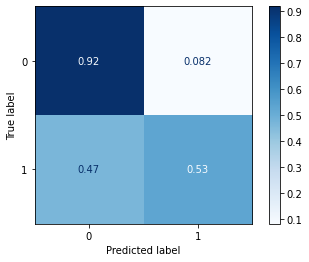

In [33]:
plot_confusion_matrix(estimator=best_model_rfc, X=features_test, y_true=target_test,
                      normalize='true', cmap='Blues');

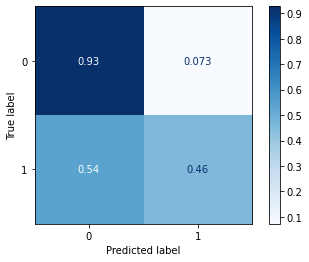

In [34]:
plot_confusion_matrix(estimator=best_model_dtc, X=features_test, y_true=target_test,
                      normalize='true', cmap='Blues');

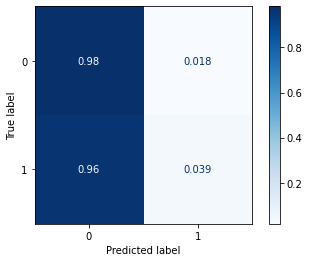

In [35]:
plot_confusion_matrix(estimator=model_lr, X=features_test, y_true=target_test,
                      normalize='true', cmap='Blues');

Из графиков видно, что все модели, особенно логистическая регрессия, хорошо предсказывают пользователей тарифа «Смарт», что нельзая сказать о пользователях «Ультра». Посмотрим на доли пользаветелей в тренировочной выборке и во всем датасете.

In [36]:
target_train.value_counts(normalize=True)

0    0.692427
1    0.307573
Name: is_ultra, dtype: float64

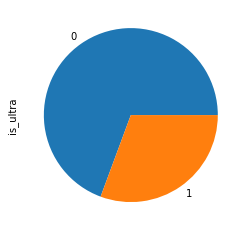

In [37]:
df.groupby('is_ultra')['is_ultra'].count().plot.pie();

Из приведенных вычислений и графика видно, что в данных присутствует дисбаланс классов, что сильно влияет на результат обучения моделей, соответственно и на предсказания.

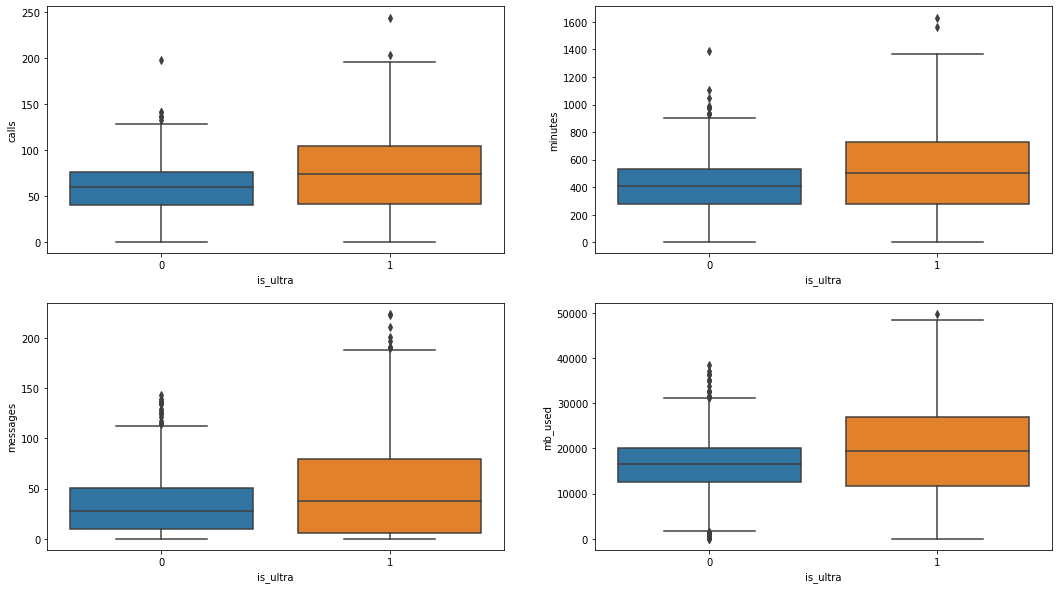

In [38]:
fig, axis = plt.subplots(2,2, figsize=(18,10))

sns.boxplot(data=df, x='is_ultra', y='calls', ax=axis[0,0])
sns.boxplot(data=df, x='is_ultra', y='minutes', ax=axis[0,1])
sns.boxplot(data=df, x='is_ultra', y='messages', ax=axis[1,0])
sns.boxplot(data=df, x='is_ultra', y='mb_used', ax=axis[1,1]);

Для улучшения результата обучения лучше избавиться от пропусков и выбросов, которые присутствуют в датасете, исходя вышепоказанных боксплотов.

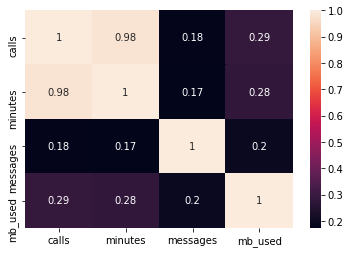

In [39]:
sns.heatmap(features.corr(), annot=True);

Проведя корреляционный анализ признаков, можно заметить сильную взаимосвязь между количеством звонков и минут разговора, что также негативно влияет на качество обучения моделей.

**Общий вывод:** для улучшения обучения необходимо избавиться от выбросов, убрать один из сильнозависящих друг от друга признаков, а также исправить дисбаланс классов. Последнюю проблему попробовал решить с помощью библиотеки imblearn, но к сожалению в ноутбуке практикума возникла ошибка при импортировании метода SMOTENC.